In [2]:
#Libraries
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [3]:
#Take the fits file to pandas for the analysis code, we only use the mu=1 data
with fits.open(r"C:\Users\clauw\Documents\Programming\Final-Project\Spatial range\solarspectrum_mu1.fits") as hdul:
    tabla = hdul[0].data

table = pd.DataFrame(tabla)

In [4]:
#Create the dataframe of raw data
raw_data = pd.DataFrame()
raw_data['Wave A'] = np.array(table.iloc[0].tolist())
raw_data['nFlux'] = np.array(table.iloc[1].tolist())
raw_data


,Wave A,nFlux
0,4200.000,0.873086
1,4200.001,0.875943
2,4200.002,0.879616
3,4200.003,0.884252
4,4200.004,0.887163
...,...,...
3799996,7999.996,0.974642
3799997,7999.997,0.974583
3799998,7999.998,0.974533
3799999,7999.999,0.974483


In [5]:
#Lines from the excel file
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visible range\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
614,10425.8870
615,10426.6020
616,10535.1220
617,10580.0390


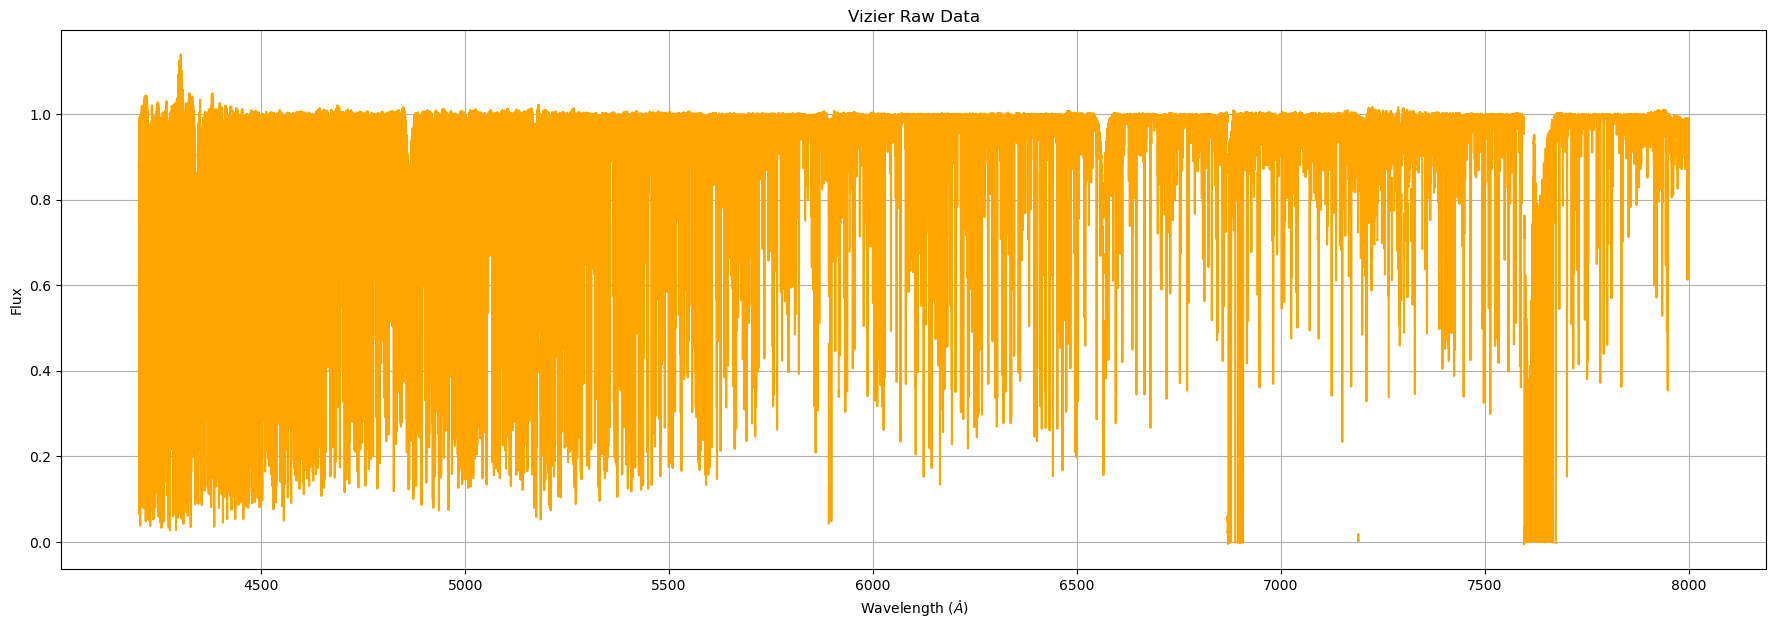

In [6]:
#Plot of raw data
fig, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(raw_data['Wave A'],raw_data['nFlux'], color='orange')
ax.set_title('Vizier Raw Data')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

### Find the minimums and the closer line of the Fe I line


In [15]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda
    closer_data = closer_data[closer_data['abs'] <= 0.025].reset_index(drop=True)

    return closer_data.drop(['abs'],axis=1)

closer_lines = find_minimums(raw_data['Wave A'],raw_data['nFlux'],raw_lambda['Nave list'])
closer_lines


,min_wave,min_flux,Fe line
0,4202.108,0.125291,4202.1078
1,4203.938,0.246928,4203.9370
2,4206.723,0.175480,4206.7233
3,4208.320,0.112591,4208.3123
4,4209.786,0.132820,4209.7896
...,...,...,...
474,7915.053,0.599777,7915.0437
475,7943.282,0.647121,7943.2736
476,7948.049,0.353895,7948.0326
477,7957.130,0.929674,7957.1226


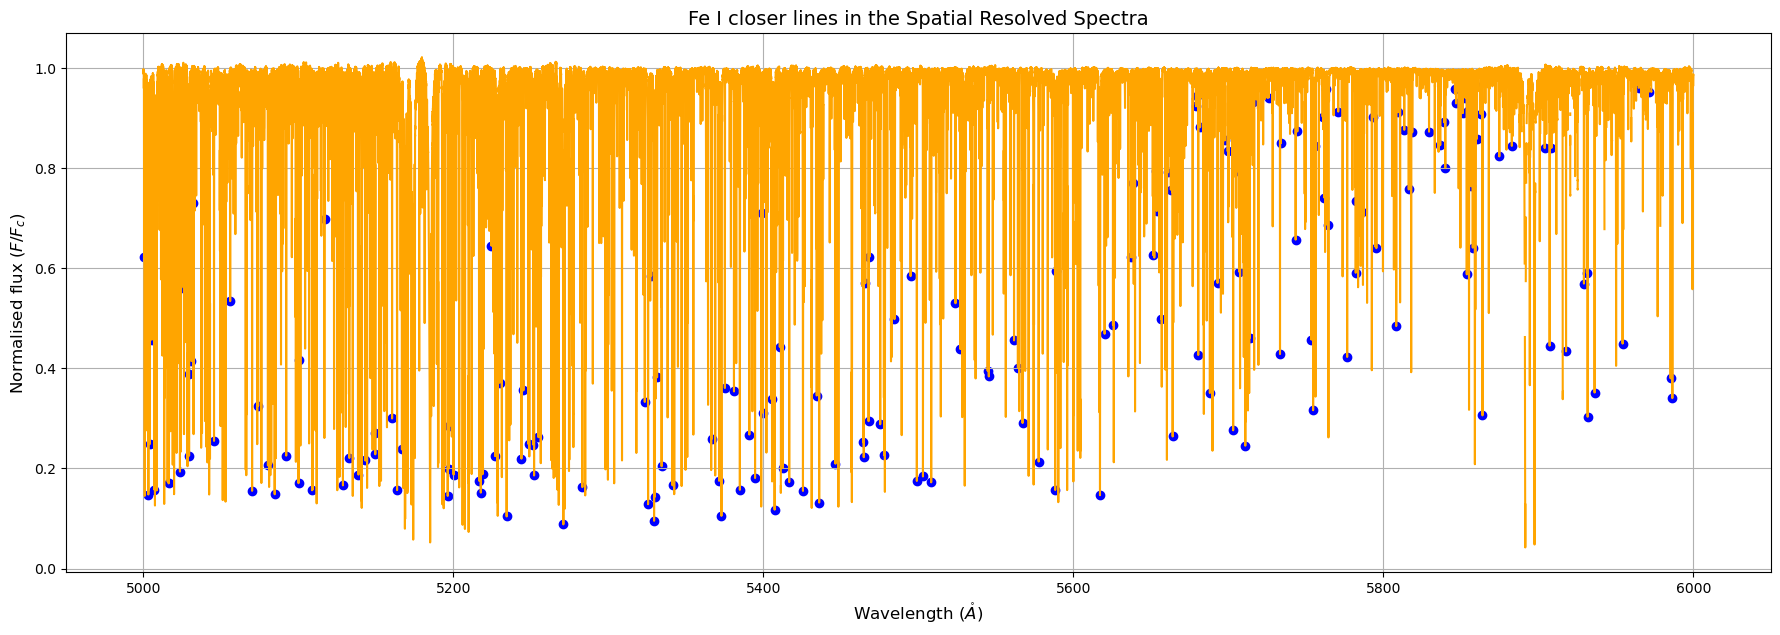

In [16]:
#Plot the identified lines
fig2, ax = plt.subplots(1,1,figsize=(22,7))

#Just for the plot, separte in the range 5000-6000 A
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000,6000,inclusive='right')]
closer_lines_5000_6000 = closer_lines[closer_lines['Fe line'].between(5000,6000,inclusive='right')]

ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')

ax.set_title('Fe I closer lines in the Spatial Resolved Spectra',fontsize=14)
ax.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=12)
ax.set_ylabel(r'Normalised flux $(F/F_{c})$',fontsize=12)
ax.grid()

In [17]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points = width_minimums(closer_lines,raw_data,0.05)

local_points

[        Wave A     nFlux
 2059  4202.059  0.586965
 2060  4202.060  0.580211
 2061  4202.061  0.571914
 2062  4202.062  0.560847
 2063  4202.063  0.546480
 ...        ...       ...
 2153  4202.153  0.493387
 2154  4202.154  0.514019
 2155  4202.155  0.535067
 2156  4202.156  0.553354
 2157  4202.157  0.570703
 
 [99 rows x 2 columns],
         Wave A     nFlux
 3889  4203.889  0.797513
 3890  4203.890  0.785363
 3891  4203.891  0.772236
 3892  4203.892  0.758670
 3893  4203.893  0.744007
 ...        ...       ...
 3983  4203.983  0.722914
 3984  4203.984  0.731983
 3985  4203.985  0.739980
 3986  4203.986  0.747797
 3987  4203.987  0.753889
 
 [99 rows x 2 columns],
         Wave A     nFlux
 6674  4206.674  0.646846
 6675  4206.675  0.638215
 6676  4206.676  0.625018
 6677  4206.677  0.608743
 6678  4206.678  0.592867
 ...        ...       ...
 6768  4206.768  0.601510
 6769  4206.769  0.608057
 6770  4206.770  0.613589
 6771  4206.771  0.620652
 6772  4206.772  0.631122
 
 [99 rows 

### Derivates and fit

In [24]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))

            #Evaluate the second and third derivate in the wavelength observed
            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","2nd Derivate","3rd Derivate","Blueshift"]

    return Values

Values = Fit_derivates(local_points,closer_lines['Fe line'])

Values = Values[Values['Flux']>0]

Values

,Emitted wavelength,Observed wavelength,Flux,Velocity,2nd Derivate,3rd Derivate,Blueshift
0,4202.1078,4202.1137,0.120261,-212,450.608527,-0.007901,420.925780
1,4203.9370,4203.9391,0.251287,-483,762.620438,-0.000098,149.755851
2,4206.7233,4206.7272,0.169646,-355,539.903829,-0.004571,277.933799
3,4208.3123,4208.3170,0.111958,-298,569.211042,-0.003034,334.819389
4,4209.7896,4209.7963,0.124643,-156,440.141820,-0.015964,477.128232
...,...,...,...,...,...,...,...
474,7915.0437,7915.0519,0.600122,-322,208.280531,-0.003822,310.585544
475,7943.2736,7943.2820,0.646910,-316,177.644139,-0.000265,317.030078
476,7948.0326,7948.0484,0.353683,-37,98.071149,-0.019203,595.961425
477,7957.1226,7957.1302,0.929205,-347,37.795244,0.027460,286.337511


In [ ]:
# #Convert to excel
# Values.to_excel('values_SPA.xlsx', index=False)

## Graphics 

As we have an absorption spectrum, the line depth is measurement one minus the flux value.

### Velocity vs Normalized Flux

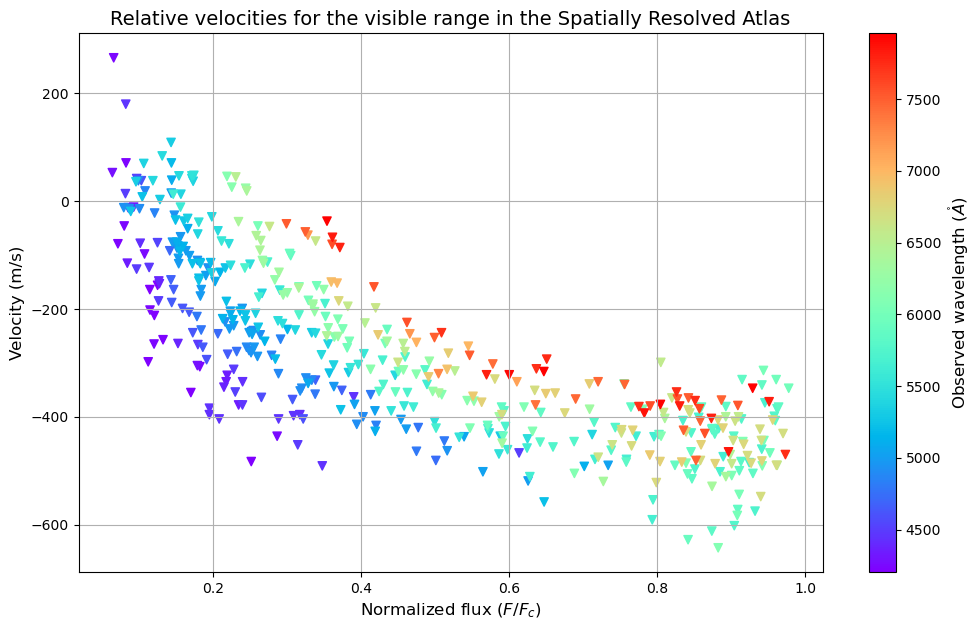

In [ ]:
fig3, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['Velocity'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Relative velocities for the visible range in the Spatially Resolved Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity_SPA.png')

### Second Derivate vs Normalized Flux

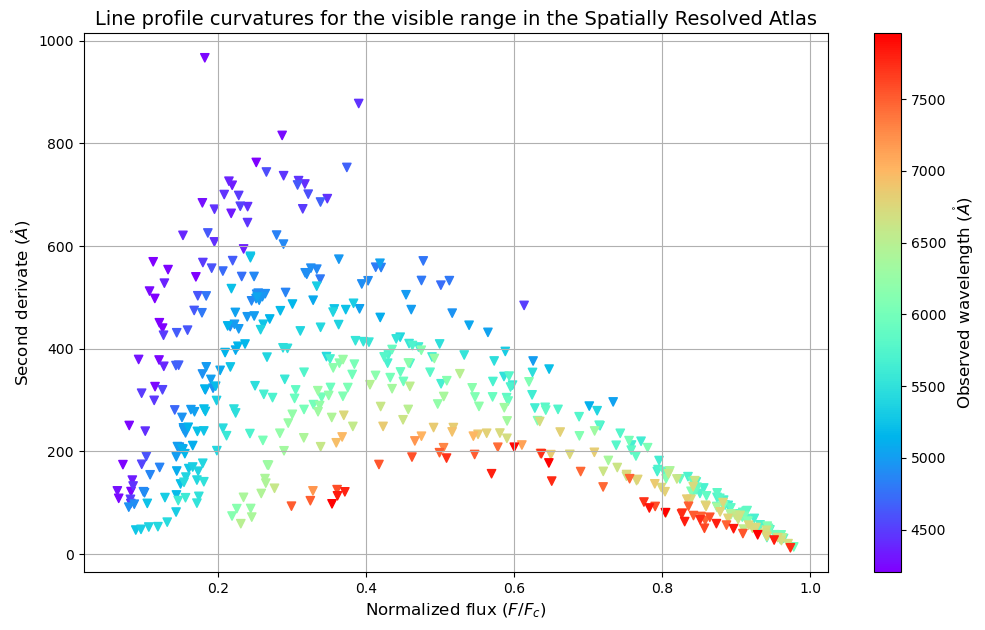

In [ ]:
fig4, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['2nd Derivate'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile curvatures for the visible range in the Spatially Resolved Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature_SPA.png')

### Third Derivate Expresion vs Normalized Flux

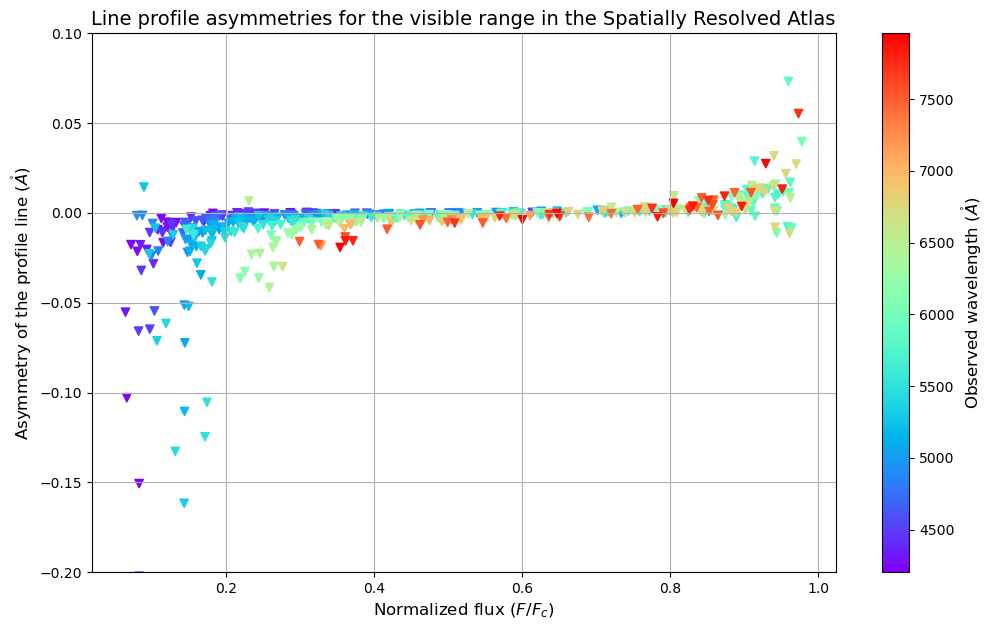

In [ ]:
fig5, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(Values['Flux'],Values['3rd Derivate'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Line profile asymmetries for the visible range in the Spatially Resolved Atlas',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Asymmetry of the profile line $(\mathring{A})$',fontsize=12)
ax.set_ylim(-0.2,0.1)
ax.grid()

# fig5.savefig('CBisector_SPA.png')

### Convective Blueshift vs Line Depth

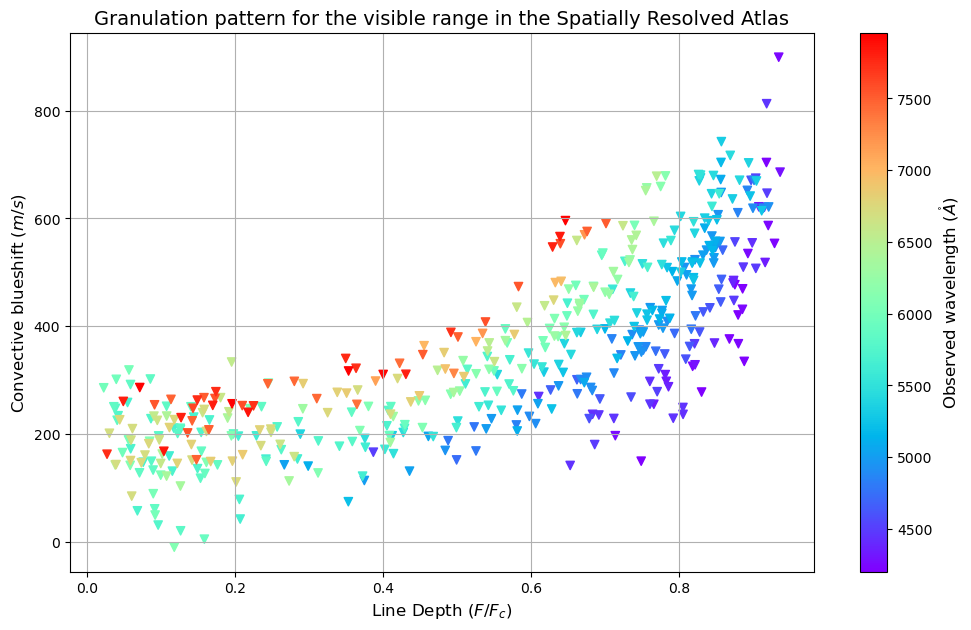

In [ ]:
fig6, ax = plt.subplots(1,1,figsize=(12,7))

scatter = ax.scatter(1-Values['Flux'],Values['Blueshift'],c=Values["Observed wavelength"],cmap='rainbow',lw=1,marker='v')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(r'Observed wavelength $(\mathring{A})$', fontsize=12)

ax.set_title('Granulation pattern for the visible range in the Spatially Resolved Atlas',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{c})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift_SPA.png')